In [1]:
import pandas as pd
import numpy as np
import os, sys, warnings, pytz
from datetime import datetime
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from scipy.stats import norm, dirichlet, invgamma, truncnorm, skewnorm, boxcox, gamma, bernoulli, gennorm, beta
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, HistGradientBoostingClassifier
import scipy.special as sc
import math
import pickle

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#calibration
def calibration(preds, actuals, groupsize = 10000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r-')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

In [4]:
from google.colab import drive
drive.mount('/drive')

#read in the field dims
field_dims = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/field_dims.csv')

#also read in the batter bip distribution estimates
batter_post = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/hitter_distribution_estimates/final_dists.csv')

#I only want to optimize for hitters who played in 2023 to save time/RAM so read those in
raw23= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

Mounted at /drive


### BIP Sampling

In [5]:
batter_post['batter_id'] = [int(batter_post.batter_id_hand.str.split('-')[i][0]) for i in range(batter_post.shape[0])]
batter_post['bat_handR'] = [int(batter_post.batter_id_hand.str.split('-')[i][1]) for i in range(batter_post.shape[0])]

#just 2023 batters
batter_post = batter_post.loc[batter_post.batter_id.isin(raw23.batter.unique())]
#reset the index
batter_post['batter_index'] = np.arange(batter_post.shape[0])

<ipython-input-5-21b3972866d2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batter_post['batter_index'] = np.arange(batter_post.shape[0])


In [6]:
#function to sample bips from a batter's distribution
def draw_samples(batter_index, N = 5000):
    batter_info = batter_post.loc[batter_post.batter_index == batter_index]

    #draw horizontal angles first
    choice = np.random.binomial(1, batter_info.batter_w1.values, size = N)
    hd_samp = choice * beta(a = batter_info.batter_alpha1.values[0], b = batter_info.batter_beta1.values[0]).rvs(N, random_state = 42) + (1-choice) * beta(a = batter_info.batter_alpha2.values[0], b = batter_info.batter_beta2.values[0]).rvs(N, random_state = 42)
    #hd_samp is between 0 and 1, so shift and scale to get it back in terms of hit directions.
    hd_samp = hd_samp * 110 -55

    #now we need to define is_pull, is_oppo, and is_mid so that we can sample from the appropriate launch angle dist
    is_pull = (hd_samp <= 0).astype(int)
    is_oppo = (hd_samp > 0).astype(int)

    #sample launch angles
    la_samp = is_pull * norm(loc = batter_info.batter_mean_pull.values[0], scale = batter_info.batter_sigma_pull.values[0]).rvs(size = N, random_state = 42) + is_oppo * norm(loc = batter_info.batter_mean_oppo.values[0], scale = batter_info.batter_sigma_oppo.values[0]).rvs(size = N, random_state = 42)

    #define the launch angle type
    is_gb = (la_samp <= 10).astype(int)
    is_ld = ((la_samp > 10).astype(int) + (la_samp <= 25).astype(int) == 2).astype(int)
    is_pu = (la_samp > 50).astype(int)
    is_fb = 1 - is_gb - is_ld - is_pu

    #sample exit speeds
    ev_samp = is_gb * gamma(a = batter_info.batter_a_gb.values[0], scale = batter_info.batter_s_gb.values[0]).rvs(size = N, random_state = 42) + is_fb * gamma(a = batter_info.batter_a_fb.values[0], scale = batter_info.batter_s_fb.values[0]).rvs(size = N, random_state = 42) + is_ld * gamma(a = batter_info.batter_a_ld.values[0], scale = batter_info.batter_s_ld.values[0]).rvs(size = N, random_state = 42) + is_pu * gamma(a = batter_info.batter_a_pu.values[0], scale = batter_info.batter_s_pu.values[0]).rvs(size = N, random_state = 42)

    return pd.DataFrame({'batter_index': [batter_index for _ in range(N)], 'is_pull': is_pull, 'is_oppo': is_oppo,
                        'is_gb': is_gb, 'is_ld': is_ld, 'is_fb': is_fb, 'is_pu': is_pu, 'hit_direction': hd_samp, 'launch_angle': la_samp, 'ev2': ev_samp})

In [7]:
samples = pd.DataFrame()
for b in batter_post.batter_index.values:
    samples = pd.concat((samples,draw_samples(b, 7500)), ignore_index = True)

In [9]:
#get batter handedness
samples = samples.merge(batter_post[['batter_index', 'batter_id', 'bat_handR']], on = 'batter_index', how = 'left')

#rescale hit direction by -1 for lefty hitters
samples.loc[samples.bat_handR == 0, 'hit_direction'] *= -1

#define the launch speed
samples['launch_speed'] = -1*(samples.ev2.values - 123)
#remove bad launch speeds
samples.loc[samples.launch_speed < 10, 'launch_speed'] = 10

#predict the landing spots and hang times
model_t = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/hangtime_model.pkl', 'rb'))
model_dist = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/landing_dist_model.pkl', 'rb'))

samples['hangtime'] = model_t.predict(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
samples['distance'] = model_dist.predict(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
#calculate landing x and y using distance and spray angle
samples['landing_x'] = samples.distance.values * np.sin(np.pi * samples.hit_direction.values / 180)
samples['landing_y'] = samples.distance.values * np.cos(np.pi * samples.hit_direction.values / 180)

#also predict xwoba given a hit for all batted balls. WE will use this to prioritize higher xwoba balls in our optimizer
xwoba_mod = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/xwoba_model.pkl', 'rb'))
#I used fangraphs 2023 woba weights
samples['xwoba'] = xwoba_mod.predict_proba(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values) @ np.array([0.883, 1.244, 1.569, 2.004])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:15:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:15:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:15:06] WARNING: /workspace/src

In [10]:
#remove the balls that likely get out of Tropicana Field
trop_dims = field_dims.loc[field_dims.stadium == 'Tropicana Field']
trop_dims['angle'] = np.arctan2(trop_dims.x.values, trop_dims.y.values)*180/np.pi
samples['wall_distance'] = [trop_dims.distance.values[np.argmin(np.abs(samples.hit_direction.values[i] - trop_dims.angle.values))] for i in range(samples.shape[0])]
samples= samples.loc[samples.distance < samples.wall_distance]

<ipython-input-10-3e7e5d9c7f2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trop_dims['angle'] = np.arctan2(trop_dims.x.values, trop_dims.y.values)*180/np.pi


In [11]:
#remove balls that land foul
samples['landing_angle'] = np.arctan2(samples.landing_x.values, samples.landing_y.values) * 180/np.pi
samples = samples.loc[np.abs(samples.landing_angle) <= 45]

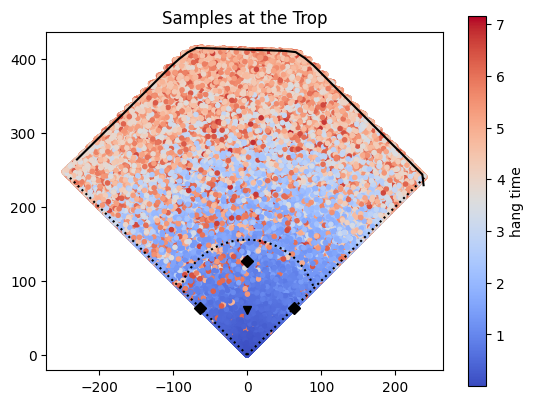

In [12]:
#plot
plt.scatter(samples.landing_x.values, samples.landing_y.values, c = samples.hangtime.values, marker = '.', cmap = 'coolwarm')
plt.colorbar(label = 'hang time')
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
mound = [0, 60.5]
circ = np.linspace(-90, 90, 100)
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.gca().set_aspect('equal')
plt.title('Samples at the Trop')
plt.show()

In [13]:
#another plot
#plt.scatter(samples.landing_x.values, samples.landing_y.values, c = samples.xwoba.values, marker = '.', cmap = 'coolwarm')
#plt.colorbar(label = 'xwOBA | Hit')
#bases_x = [0, -63.64, 63.64]
#bases_y = [127.27, 63.64, 63.64]
#mound = [0, 60.5]
#circ = np.linspace(-90, 90, 100)
#plt.plot([mound[0]], [mound[1]], 'kv')
#plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
#plt.plot(bases_x, bases_y, 'kD')
#plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
#plt.plot([0,240], [0,240], 'k:')
#plt.plot([0,-240], [0,240], 'k:')
#plt.gca().set_aspect('equal')
#plt.title('Samples at the Trop')
#plt.show()

In [14]:
#note, the groundball and flyball model are separate, so it doesn't hurt us to add more groundballs to the data to make sure we learn infield positioning well enough
gb = samples.loc[samples.is_gb == 1]
fb = samples.loc[samples.is_gb == 0]
gb2 = gb.sample(frac = 2, replace = True)
samples = pd.concat((gb, gb2, fb))
del gb
del fb
del gb2

### Optimizing

In [15]:
#define the coefficients in the fly ball linear model and ground ball linear model. I got these from the respective notebooks in the positioning_development/play_probs_and_xwoba_model_building folder
#### Groundball
gb_int =-2.7808253
gb_angle_diff = -0.1463456
gb_bttf = 5.86696302
gb_bttf2 = -1.31835977

#### Fly ball regression model coefficients
fb_int = -2.16869748
fb_td_slope = 1.50402427

In [16]:
class DataSet(Dataset):
    def __init__(self, x,y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)

        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

#for the linear models, we need the landing coordinates, the hang time, the exit speed, the hit direction

features = ['landing_x', 'landing_y', 'launch_speed', 'hit_direction', 'hangtime', 'distance', 'is_gb', 'batter_index']

train_x = samples[features].values
train_y = samples.xwoba.values
trainset = DataSet(train_x, train_y)

trainloader = DataLoader(trainset, batch_size = 2048, shuffle = True)

In [17]:
#define a constraint function. Note that the embedding layer will not necessarily have the constraints applied, so we need to apply them before we make fielding recs
def constraint_func(bat_emb, constraint_type = 1):

    #first base constraint: must be within 40 feet from firstbase so he can cover the bag
    _1b = torch.tensor([[63.64, 63.64]]).to(device)
    p1b = bat_emb[:,0:2] - _1b
    _1b_dist = torch.norm(p1b, dim = 1)
    _1b_angle = torch.atan2(p1b[:,0], p1b[:,1])
    _1b_dist2 = _1b_dist.clone()
    #reset dists that are too far
    _1b_dist2[_1b_dist > 40] = 40.
    #reset coordinates by maintaining the same angle with first base but shrinking the distance
    p1bx = _1b_dist2 * torch.sin(_1b_angle) + 63.64
    p1by = _1b_dist2 * torch.cos(_1b_angle) + 63.64

    if constraint_type == 2:
      #shift ban constraint: infielders have to be in dirt and two on either side of second base.
      #That means we need the distance from each fielder to the center of the mound to be less than 95 ft based on this article: https://angelsnation.com/mlb-to-begin-enforcing-length-of-infield-dirt-at-stadiums/2022/10/23/
      #get the coordinates of the infielders relative to the mound
      mound = torch.tensor([[0, 60.5]]).to(device)
      mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
      mp4 = bat_emb[:,2:4] - mound
      mp5 = bat_emb[:,4:6] - mound
      mp6 = bat_emb[:,6:8] - mound

      #get the player angles relative to the mound
      ma3 = torch.atan2(mp3[:,0], mp3[:,1])
      ma4 = torch.atan2(mp4[:,0], mp4[:,1])
      ma5 = torch.atan2(mp5[:,0], mp5[:,1])
      ma6 = torch.atan2(mp6[:,0], mp6[:,1])

      #get the depths relative to the mound. these will need to be less than or equal to 95 in order to stay in the dirt
      md3 = torch.norm(mp3, dim = 1)
      md4 = torch.norm(mp4, dim = 1)
      md5 = torch.norm(mp5, dim = 1)
      md6 = torch.norm(mp6, dim = 1)

      #reset depths greater than 95 to be 95. I think we need to clone these in order for backprop to work, but I'm not sure
      md32 = md3.clone()
      md42 = md4.clone()
      md52 = md5.clone()
      md62 = md6.clone()
      md32[md3 > 95] = 95.
      md42[md4 > 95] = 95.
      md52[md5 > 95] = 95.
      md62[md6 > 95] = 95.

      #reset illegal angles (by the shift ban) to be legal once again we need to clone
      ma32 = ma3.clone()
      ma42 = ma4.clone()
      ma52 = ma5.clone()
      ma62 = ma6.clone()
      ma32[ma3 < 0] = 0.
      ma42[ma4 < 0] = 0.
      ma52[ma5 > 0] = 0.
      ma62[ma6 > 0] = 0.

      #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
      x3 = md32 * torch.sin(ma32)
      y3 = md32 * torch.cos(ma32)
      x4 = md42 * torch.sin(ma42)
      y4 = md42 * torch.cos(ma42)
      x5 = md52 * torch.sin(ma52)
      y5 = md52 * torch.cos(ma52)
      x6 = md62 * torch.sin(ma62)
      y6 = md62 * torch.cos(ma62)

      #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
      y3 = y3 + 60.5
      y4 = y4 + 60.5
      y5 = y5 + 60.5
      y6 = y6 + 60.5
      #define a new embedding with the constraints adjusted for
      bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

    else:
      #no shift ban
      bat_emb2 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1), bat_emb[:,2:].clone()), dim = 1)

    return bat_emb2

In [18]:
class Optimizer(nn.Module):
    def __init__(self, constraint_type = 1):
        super().__init__()

        self.embed = nn.Embedding(samples.batter_index.max() + 1, embedding_dim = 14).to(device)

        #initialize the embedding
        default = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
        self.embed.weight.data = torch.tensor(default, dtype = torch.float32).repeat((samples.batter_index.max()+1,1)).to(device)

        #the constraint types are 1 and 2. 1 is no constraints except firstbaseman has to be able to cover. 2 is shift ban constraints from 2023
        self.constraint_type = constraint_type

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb = self.embed(batter_idx)

        #first base constraint: must be within 40 feet from firstbase so he can cover the bag
        _1b = torch.tensor([[63.64, 63.64]]).to(device)
        p1b = bat_emb[:,0:2] - _1b
        _1b_dist = torch.norm(p1b, dim = 1)
        _1b_angle = torch.atan2(p1b[:,0], p1b[:,1])
        _1b_dist2 = _1b_dist.clone()
        #reset dists that are too far
        _1b_dist2[_1b_dist > 40] = 40.
        #reset coordinates by maintaining the same angle with first base but shrinking the distance
        p1bx = _1b_dist2 * torch.sin(_1b_angle) + 63.64
        p1by = _1b_dist2 * torch.cos(_1b_angle) + 63.64

        if self.constraint_type == 2:
          #shift ban constraint: infielders have to be in dirt and two on either side of second base.
          #That means we need the distance from each fielder to the center of the mound to be less than 95 ft based on this article: https://angelsnation.com/mlb-to-begin-enforcing-length-of-infield-dirt-at-stadiums/2022/10/23/
          #get the coordinates of the infielders relative to the mound
          mound = torch.tensor([[0, 60.5]]).to(device)
          mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
          mp4 = bat_emb[:,2:4] - mound
          mp5 = bat_emb[:,4:6] - mound
          mp6 = bat_emb[:,6:8] - mound

          #get the player angles relative to the mound
          ma3 = torch.atan2(mp3[:,0], mp3[:,1])
          ma4 = torch.atan2(mp4[:,0], mp4[:,1])
          ma5 = torch.atan2(mp5[:,0], mp5[:,1])
          ma6 = torch.atan2(mp6[:,0], mp6[:,1])

          #get the depths relative to the mound. these will need to be less than or equal to 95 in order to stay in the dirt
          md3 = torch.norm(mp3, dim = 1)
          md4 = torch.norm(mp4, dim = 1)
          md5 = torch.norm(mp5, dim = 1)
          md6 = torch.norm(mp6, dim = 1)

          #reset depths greater than 95 to be 95. I think we need to clone these in order for backprop to work, but I'm not sure
          md32 = md3.clone()
          md42 = md4.clone()
          md52 = md5.clone()
          md62 = md6.clone()
          md32[md3 > 95] = 95.
          md42[md4 > 95] = 95.
          md52[md5 > 95] = 95.
          md62[md6 > 95] = 95.

          #reset illegal angles (by the shift ban) to be legal once again we need to clone
          ma32 = ma3.clone()
          ma42 = ma4.clone()
          ma52 = ma5.clone()
          ma62 = ma6.clone()
          ma32[ma3 < 0] = 0.
          ma42[ma4 < 0] = 0.
          ma52[ma5 > 0] = 0.
          ma62[ma6 > 0] = 0.

          #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
          x3 = md32 * torch.sin(ma32)
          y3 = md32 * torch.cos(ma32)
          x4 = md42 * torch.sin(ma42)
          y4 = md42 * torch.cos(ma42)
          x5 = md52 * torch.sin(ma52)
          y5 = md52 * torch.cos(ma52)
          x6 = md62 * torch.sin(ma62)
          y6 = md62 * torch.cos(ma62)

          #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
          y3 = y3 + 60.5
          y4 = y4 + 60.5
          y5 = y5 + 60.5
          y6 = y6 + 60.5
          #define a new embedding with the constraints adjusted for
          bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

        else:
          #no shift ban
          bat_emb2 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1), bat_emb[:,2:].clone()), dim = 1)

        #################################################################################################################################################################################################
        #get fielder depths
        first_depth = torch.norm(bat_emb2[:,:2], dim = 1).unsqueeze(1)
        second_depth = torch.norm(bat_emb2[:,2:4], dim = 1).unsqueeze(1)
        third_depth = torch.norm(bat_emb2[:,4:6], dim = 1).unsqueeze(1)
        ss_depth = torch.norm(bat_emb2[:,6:8], dim = 1).unsqueeze(1)
        lf_depth = torch.norm(bat_emb2[:,8:10], dim = 1).unsqueeze(1)
        cf_depth = torch.norm(bat_emb2[:,10:12], dim = 1).unsqueeze(1)
        rf_depth = torch.norm(bat_emb2[:,12:14], dim = 1).unsqueeze(1)
        depths = torch.cat((first_depth, second_depth, third_depth, ss_depth, lf_depth, cf_depth, rf_depth), dim = -1)

        ##### Flyballs
        # we need the closest fielder to the landing spot
        landing_spot = x[:,:2]
        first_dist = torch.norm(bat_emb2[:,:2] - landing_spot, dim = 1).unsqueeze(1)
        second_dist = torch.norm(bat_emb2[:,2:4] - landing_spot, dim = 1).unsqueeze(1)
        third_dist = torch.norm(bat_emb2[:,4:6] - landing_spot, dim = 1).unsqueeze(1)
        ss_dist = torch.norm(bat_emb2[:,6:8] - landing_spot, dim = 1).unsqueeze(1)
        lf_dist = torch.norm(bat_emb2[:,8:10] - landing_spot, dim = 1).unsqueeze(1)
        cf_dist = torch.norm(bat_emb2[:,10:12] - landing_spot, dim = 1).unsqueeze(1)
        rf_dist = torch.norm(bat_emb2[:,12:14] - landing_spot, dim = 1).unsqueeze(1)
        dists = torch.cat((first_dist, second_dist, third_dist, ss_dist, lf_dist, cf_dist, rf_dist), dim = -1)
        mindist, mindist_index = torch.min(dists, dim = 1)
        #now we need the timediff, which is the time it takes an average runner (27 ft/s) to cover mindist subtracted from the hang time
        timediff = x[:,4] - (mindist / 27)

        #now we can calculate fly ball out probability
        fb_prob_outs = torch.special.expit(fb_int + timediff * fb_td_slope)

        #### Groundballs
        #calculate fielder angles
        a3 = torch.arctan2(bat_emb2[:,0], bat_emb2[:,1]) * 180/np.pi
        a4 = torch.arctan2(bat_emb2[:,2], bat_emb2[:,3]) * 180/np.pi
        a5 = torch.arctan2(bat_emb2[:,4], bat_emb2[:,5]) * 180/np.pi
        a6 = torch.arctan2(bat_emb2[:,6], bat_emb2[:,7]) * 180/np.pi
        a7 = torch.arctan2(bat_emb2[:,8], bat_emb2[:,9]) * 180/np.pi
        a8 = torch.arctan2(bat_emb2[:,10], bat_emb2[:,11]) * 180/np.pi
        a9 = torch.arctan2(bat_emb2[:,12], bat_emb2[:,13]) * 180/np.pi

        #get the angle diffs
        hd = x[:,3]
        ad3 = (a3 -hd).unsqueeze(1)
        ad4 = (a4-hd).unsqueeze(1)
        ad5 = (a5-hd).unsqueeze(1)
        ad6 = (a6-hd).unsqueeze(1)
        ad7 = (a7-hd).unsqueeze(1)
        ad8 = (a8-hd).unsqueeze(1)
        ad9 = (a9-hd).unsqueeze(1)
        angle_diffs = torch.cat((ad3, ad4, ad5, ad6, ad7, ad8, ad9), dim = -1)

        #get the closest infielder by absolute angle dist, so we need to make sure non infielders aren't counted by setting their values really large
        inf_ad3 = ad3.clone()
        inf_ad4 = ad4.clone()
        inf_ad5 = ad5.clone()
        inf_ad6 = ad6.clone()
        inf_ad7 = ad7.clone()
        inf_ad8 = ad8.clone()
        inf_ad9 = ad9.clone()
        inf_ad3[first_depth > 200] = 1000.
        inf_ad4[second_depth > 200] = 1000.
        inf_ad5[third_depth > 200] = 1000.
        inf_ad6[ss_depth > 200] = 1000.
        inf_ad7[lf_depth > 200] = 1000.
        inf_ad8[cf_depth > 200] = 1000.
        inf_ad9[rf_depth > 200] = 1000.
        inf_vals = torch.abs(torch.cat((inf_ad3, inf_ad4, inf_ad5, inf_ad6, inf_ad7, inf_ad8, inf_ad9), dim = -1))
        closest_ifer, closest_ifer_index = torch.min(inf_vals, dim = 1)
        #we need their depth and absolute angle diff
        closest_ifer_depth = depths[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1)
        closest_ifer_angle = torch.abs(angle_diffs[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1))
        #calcluate the ball time to fielder, depth divided by exit speed in feet per second.
        bttf = closest_ifer_depth.squeeze(1) / (x[:,2] * 1.4667)

        #now we can calculate ground ball out probability using the regression model
        gb_prob_outs = torch.special.expit(gb_int + gb_angle_diff * closest_ifer_angle.squeeze(1) + gb_bttf * bttf + gb_bttf2 * bttf**2)

        #the final out probability depends on if it is a ground ball or fly ball
        is_gb = x[:,6]
        return is_gb * gb_prob_outs + (1-is_gb) * fb_prob_outs

In [19]:
op = Optimizer().to(device)
x = trainset[:10][0].to(device)
op(x)

tensor([0.8614, 0.7436, 0.5571, 0.6983, 0.7761, 0.7310, 0.5142, 0.8073, 0.5501,
        0.6393], device='cuda:0', grad_fn=<AddBackward0>)

In [20]:
#define my custom loss function, maximize outs, so minimize negative outs
def maximize_outs(output, target = None):
    #we just return the negative mean of outs. We want to minimze that
    return -1*torch.mean(output)*1000

#minimize woba
def minimize_woba(output, target):
    #output would obviously be the output of the net, which is an out probability. Target is the woba of a hit, so we take 1-out prob and multiply that by target, and that gives xwoba of a non out, and we want to minimize this
    return torch.mean((1-output) * target)*1000

In [21]:
#training parameters
learning_rate = 1
epochs = 5
loss_fn = minimize_woba

epoch : 1/5, loss = 253.020200
epoch : 2/5, loss = 243.923311
epoch : 3/5, loss = 242.370993
epoch : 4/5, loss = 241.283859
epoch : 5/5, loss = 240.573816


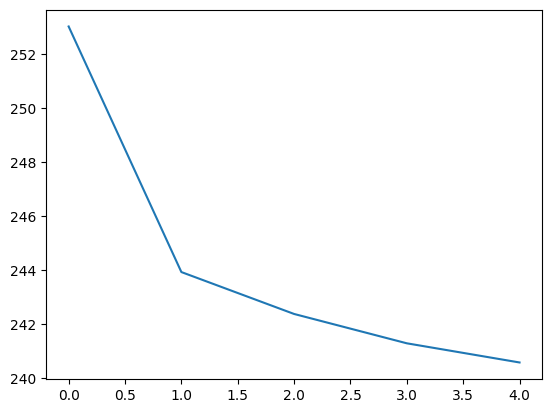

In [22]:
#shift ban
opt1 = Optimizer(2).to(device)
optimizer = torch.optim.SGD(opt1.parameters(), lr = learning_rate, momentum = 0.9)
train_losses = []

#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        outputs = opt1(x)
        #calculate loss
        loss = loss_fn(outputs, y)
        loss_val += loss.item()
        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(trainloader))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

plt.plot(train_losses)
plt.show()

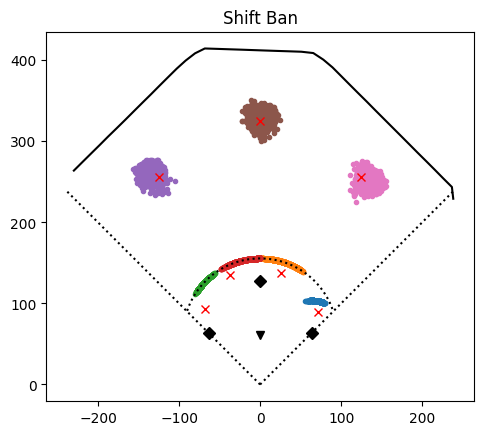

In [26]:
#plot the results
batter_weights1 = pd.DataFrame({'batter_index': [i for i in range(samples.batter_index.max()+1)]})
bat_embeddings = opt1.embed.weight.data
constrained = constraint_func(bat_embeddings, 2)
batter_weights1[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9']] = constrained.detach().cpu().numpy()

standard_pos = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
circ = np.linspace(-90, 90, 100)
mound = [0, 60.5]
for i in range(7):
    plt.plot(batter_weights1['x' + str(i + 3)], batter_weights1['y' + str(i+3)], '.')
    plt.plot([standard_pos[2*i]], [standard_pos[2*i+1]], 'rx')
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.gca().set_aspect('equal')
plt.title('Shift Ban')
plt.show()

In [27]:
#save the 2023 shift ban constraints
batter_weights1 = batter_weights1.merge(batter_post[['batter_id', 'bat_handR', 'batter_index']], on = 'batter_index')
batter_weights1.drop(columns = 'batter_index', inplace = True)

In [28]:
batter_weights1.to_csv('/drive/My Drive/Colab Notebooks/positioning_project/positioning_optimization/recs_2023.csv', index=False)